In [1]:
#1. rutin1 import module
import pandas as pd
import os
import sys
import warnings
import matplotlib.pyplot as plt

import networkx as nx
from collections import defaultdict

warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
#2. rutin2 membuat syspath ke root utk aktifkan __init__.py
repo_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(repo_root)

In [3]:
#3. rutin3 Load the dataset
dataset_path = os.path.join(repo_root, "data/dataset_ekstraksi_r30_lg.xlsx")
df = pd.read_excel(dataset_path)
df["text"] = df["judul"] +". "+ df["isi"]

In [4]:
# Preprocess
import re
'''
stopwords tidak masuk dalam preprocessing
'''
def preprocess(text):
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = text.replace('.', '. ')
    text = re.sub('[^a-zA-Z.]', ' ', text)
    text = text.lower()
    text = re.sub("(\\d|\\W)+"," ",text)
    text = text.strip()

    return text

df["text"] = df['text'].apply(preprocess)
df["judul"] = df["judul"].apply(preprocess)

In [5]:
stopwords_path = os.path.join(repo_root, "notebooks/stopwords_tuning/all_stop_words.txt")
with open(stopwords_path, 'r') as file:
    stopwords = set(file.read().strip().splitlines())

In [6]:
from collections import Counter
from nlp_id_local.tokenizer import PhraseTokenizer 
from nlp_id_local.postag import PosTag
from nltk.util import ngrams


def generate_ngrams(words, n=2):
    """Generate ngrams from a list of words."""
    return [" ".join(gram) for gram in ngrams(words, n)]

def detect_bigram(text):
    
    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only bigrams whose individual words are in available_tokens
    bigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 1]

    return bigrams_only

def detect_trigram(text):

    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only trigrams whose individual words are in available_tokens
    trigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 2 ]

    return trigrams_only

def detect_all_tokens(text):
    unigrams = [word for word in text.split()]
    bigrams = detect_bigram(text)
    trigrams = detect_trigram(text)
    
    # Combine unigrams, filtered bigrams, and filtered trigrams
    all_tokens = unigrams + bigrams + trigrams

    return all_tokens

def visualize_graph(G, labels):
    # Remove self-loops (edges that connect a node to itself)
    G.remove_edges_from(nx.selfloop_edges(G))

    fig = plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    #nx.draw(G, pos=pos, with_labels=False, font_weight="bold", node_size=5000, node_color='skyblue')
    nx.draw(G, pos=pos, with_labels=False, font_weight="bold")
    nx.draw_networkx_labels(G, pos, labels, font_size=12)
    plt.show()

EXPLORATORY

12_TextRank Cooccurences

In [8]:
text = df["text"][0] 
text

'usulan personil penting proposed key personnel menunjuk surat kontraktor no jtb rj pj b tertanggal oktober perihal usulan personil penting yang baru sebagai pengganti dari personil penting yang sudah diajukan pada saat fase tender dengan ini disampaikan bahwa perusahaan memerlukan beberapa tambahan penjelasan dari kontraktor perusahaan dapat memahami terjadinya pergantian personil penting yang disebabkan oleh cukup lama nya durasi antara pengumuman pemenang lelang dan tanggal efektif dari kontrak dalam hal ini perusahaan mengharapkan personil pengganti memiliki kualifikasi yang minimal sama dengan kualifikasi personil penting yang sudah diajukan pada saat fase tender akan tetapi perusahaan tidak mengharapkan kontraktor melakukan perubahan terhadap organisasi yang diajukan pada saat fase tender hal ini adalah karena baik organisasi maupun personil penting yang diajukan pada saat fase tender termasuk salah satu faktor yang menentukan penilaian teknis dari penawaran selain itu dapat diin

In [ ]:
import string

words = detect_all_tokens(text)
# Load stopwords for the specified language
stop_words = stopwords
    
# Filter out stopwords and punctuation
words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
words

In [12]:
co_occurrence = defaultdict(int)
window_size = 3
for i in range(len(words) - window_size + 1):
    window = words[i:i+window_size]
    for j in range(window_size):
        for k in range(j+1, window_size):
            w1, w2 = sorted([window[j], window[k]])
            if w1 != w2:
                co_occurrence[(w1, w2)] += 1
    
# Build a graph
G = nx.Graph()
for (w1, w2), weight in co_occurrence.items():

    G.add_edge(w1, w2, weight=weight)
    
# Compute TextRank scores
scores = nx.pagerank(G)
scores

{'personil': 0.06478255672135048,
 'usulan': 0.0171408899539784,
 'proposed': 0.009368550796900736,
 'key': 0.010240845702288457,
 'personnel': 0.010843178707648232,
 'b': 0.010882781762336044,
 'tertanggal': 0.010420223591834032,
 'oktober': 0.009547928686446308,
 'pengganti': 0.03320964838074254,
 'diajukan': 0.032870739333525856,
 'fase': 0.033137671580682204,
 'tender': 0.03543252961672592,
 'tambahan': 0.007968265116710043,
 'penjelasan': 0.015589086212565918,
 'memahami': 0.008822795852126213,
 'pergantian': 0.008870824559042569,
 'disebabkan': 0.0097188830008071,
 'nya': 0.01052187180391817,
 'durasi': 0.011228663639980254,
 'pengumuman': 0.01139357498487258,
 'pemenang': 0.011205585989637808,
 'lelang': 0.01052884678886716,
 'efektif': 0.00951897191361525,
 'mengharapkan': 0.01394706259758167,
 'memiliki': 0.008217974370586037,
 'kualifikasi': 0.012732428671053144,
 'minimal': 0.008465500668757444,
 'organisasi': 0.03192451134438839,
 'salah': 0.008984390224168335,
 'faktor': 0

In [13]:
# Prepare labels
labels = {node: f'{node}\n({score:.2f})' for node, score in scores.items()}
labels 

{'personil': 'personil\n(0.06)',
 'usulan': 'usulan\n(0.02)',
 'proposed': 'proposed\n(0.01)',
 'key': 'key\n(0.01)',
 'personnel': 'personnel\n(0.01)',
 'b': 'b\n(0.01)',
 'tertanggal': 'tertanggal\n(0.01)',
 'oktober': 'oktober\n(0.01)',
 'pengganti': 'pengganti\n(0.03)',
 'diajukan': 'diajukan\n(0.03)',
 'fase': 'fase\n(0.03)',
 'tender': 'tender\n(0.04)',
 'tambahan': 'tambahan\n(0.01)',
 'penjelasan': 'penjelasan\n(0.02)',
 'memahami': 'memahami\n(0.01)',
 'pergantian': 'pergantian\n(0.01)',
 'disebabkan': 'disebabkan\n(0.01)',
 'nya': 'nya\n(0.01)',
 'durasi': 'durasi\n(0.01)',
 'pengumuman': 'pengumuman\n(0.01)',
 'pemenang': 'pemenang\n(0.01)',
 'lelang': 'lelang\n(0.01)',
 'efektif': 'efektif\n(0.01)',
 'mengharapkan': 'mengharapkan\n(0.01)',
 'memiliki': 'memiliki\n(0.01)',
 'kualifikasi': 'kualifikasi\n(0.01)',
 'minimal': 'minimal\n(0.01)',
 'organisasi': 'organisasi\n(0.03)',
 'salah': 'salah\n(0.01)',
 'faktor': 'faktor\n(0.01)',
 'menentukan': 'menentukan\n(0.01)',
 'pen

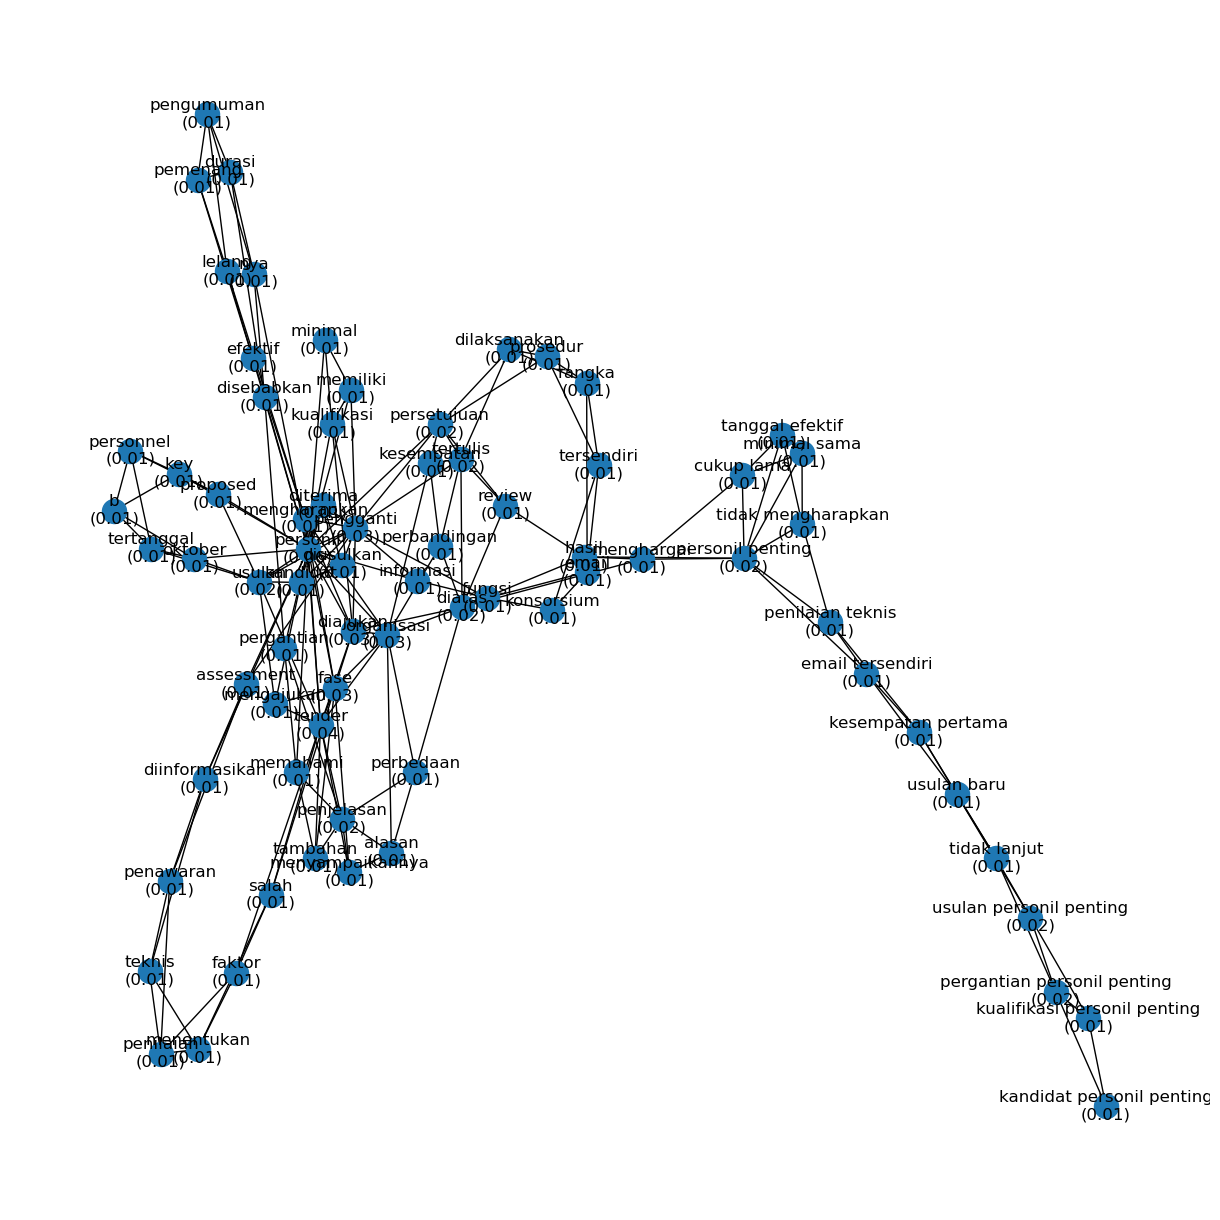

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize the graph
visualize_graph(G, labels)


13a_TextRank_w2v_lg_similarity

In [15]:
import os
from gensim.models import Word2Vec

def load_word2vec_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"The provided Word2Vec model path does not exist: {model_path}")
    
    w2v_model = Word2Vec.load(model_path) 
    available_tokens = set(w2v_model.wv.key_to_index)
    
    return w2v_model, available_tokens

# Example usage
model_path = os.path.join(repo_root, "models/w2v_200/idwiki_word2vec_200_new_lower.model")
w2v_model, available_tokens = load_word2vec_model(model_path)

# Show a sample of available tokens
sample_tokens = list(available_tokens)[:5]
sample_tokens

from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(w1, w2, w2v_model):
    if w1 not in w2v_model.wv or w2 not in w2v_model.wv:
        return 0
    vec1 = w2v_model.wv[w1]
    vec2 = w2v_model.wv[w2]
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    return similarity


In [16]:
# Example usage
model_path = os.path.join(repo_root, "models/w2v_200/idwiki_word2vec_200_new_lower.model")
w2v_model, available_tokens = load_word2vec_model(model_path)

# Show a sample of available tokens
sample_tokens = list(available_tokens)[:5]
sample_tokens

['undangannya', 'larceny', 'nuari', 'jungk', 'freha']

In [17]:
co_occurrence = defaultdict(int)
window_size = 3
for i in range(len(words) - window_size + 1):
    window = words[i:i+window_size]
    for j in range(window_size):
        for k in range(j+1, window_size):
            w1, w2 = sorted([window[j], window[k]])
            if w1 != w2:
                co_occurrence[(w1, w2)] += 1
    
# Build a graph
G = nx.Graph()
for (w1, w2), _ in co_occurrence.items():
    weight = get_cosine_similarity(w1, w2, w2v_model)
    print('weight: ',weight)
    if weight > 0:
        G.add_edge(w1, w2, weight=weight)
    
# Compute TextRank scores
scores = nx.pagerank(G)
scores

weight:  0.10780747
weight:  0.0681381
weight:  0.023884866
weight:  0.1721807
weight:  0.3388049
weight:  0.6303966
weight:  0.34804836
weight:  0
weight:  0
weight:  -0.039551273
weight:  0
weight:  0
weight:  0.2097131
weight:  0.2783746
weight:  0.16057771
weight:  0.14942741
weight:  0.1838383
weight:  0.15936404
weight:  0.1367668
weight:  -0.060202215
weight:  0.07624936
weight:  0.030948361
weight:  0.25516796
weight:  0.13957797
weight:  0.1520823
weight:  0.1946238
weight:  0.012021588
weight:  0.3218594
weight:  0.061435208
weight:  0.38766134
weight:  0.1336774
weight:  -0.0017715916
weight:  -0.045436196
weight:  0.1629337
weight:  0.037744943
weight:  0.01875211
weight:  0.006383799
weight:  0.0138553595
weight:  0.17153172
weight:  0.13901156
weight:  0.15812932
weight:  0.18936001
weight:  0.11101821
weight:  0.23621383
weight:  0.38835913
weight:  0.1380723
weight:  -0.06544904
weight:  0.06556165
weight:  0.07079215
weight:  0.17945491
weight:  0.06873658
weight:  0.0

{'personil': 0.03576060979746561,
 'usulan': 0.03147173166053382,
 'proposed': 0.01905534961318465,
 'key': 0.015980474748906508,
 'personnel': 0.017709054895727123,
 'oktober': 0.01136081761007646,
 'tertanggal': 0.010639833240358514,
 'pengganti': 0.03812488316544278,
 'diajukan': 0.01857765043140848,
 'fase': 0.013281447222938354,
 'tender': 0.023222773309888478,
 'tambahan': 0.01527772163657665,
 'penjelasan': 0.036173511727479124,
 'memahami': 0.010370659435003815,
 'pergantian': 0.008756639764181772,
 'disebabkan': 0.0086452409791135,
 'nya': 0.01048964994336032,
 'durasi': 0.01892323424857119,
 'pengumuman': 0.02686615738882418,
 'pemenang': 0.01424411967721092,
 'lelang': 0.017980158846056117,
 'efektif': 0.008551417237441919,
 'mengharapkan': 0.01794405988591901,
 'memiliki': 0.008911748710384257,
 'kualifikasi': 0.013567436057192997,
 'minimal': 0.01593011357608338,
 'organisasi': 0.02068558289594756,
 'salah': 0.008689999962330098,
 'faktor': 0.017396294082008035,
 'menentuk

In [18]:
# Prepare labels
labels = {node: f'{node}\n({score:.2f})' for node, score in scores.items()}
labels 

{'personil': 'personil\n(0.04)',
 'usulan': 'usulan\n(0.03)',
 'proposed': 'proposed\n(0.02)',
 'key': 'key\n(0.02)',
 'personnel': 'personnel\n(0.02)',
 'oktober': 'oktober\n(0.01)',
 'tertanggal': 'tertanggal\n(0.01)',
 'pengganti': 'pengganti\n(0.04)',
 'diajukan': 'diajukan\n(0.02)',
 'fase': 'fase\n(0.01)',
 'tender': 'tender\n(0.02)',
 'tambahan': 'tambahan\n(0.02)',
 'penjelasan': 'penjelasan\n(0.04)',
 'memahami': 'memahami\n(0.01)',
 'pergantian': 'pergantian\n(0.01)',
 'disebabkan': 'disebabkan\n(0.01)',
 'nya': 'nya\n(0.01)',
 'durasi': 'durasi\n(0.02)',
 'pengumuman': 'pengumuman\n(0.03)',
 'pemenang': 'pemenang\n(0.01)',
 'lelang': 'lelang\n(0.02)',
 'efektif': 'efektif\n(0.01)',
 'mengharapkan': 'mengharapkan\n(0.02)',
 'memiliki': 'memiliki\n(0.01)',
 'kualifikasi': 'kualifikasi\n(0.01)',
 'minimal': 'minimal\n(0.02)',
 'organisasi': 'organisasi\n(0.02)',
 'salah': 'salah\n(0.01)',
 'faktor': 'faktor\n(0.02)',
 'menentukan': 'menentukan\n(0.02)',
 'penilaian': 'penilaian

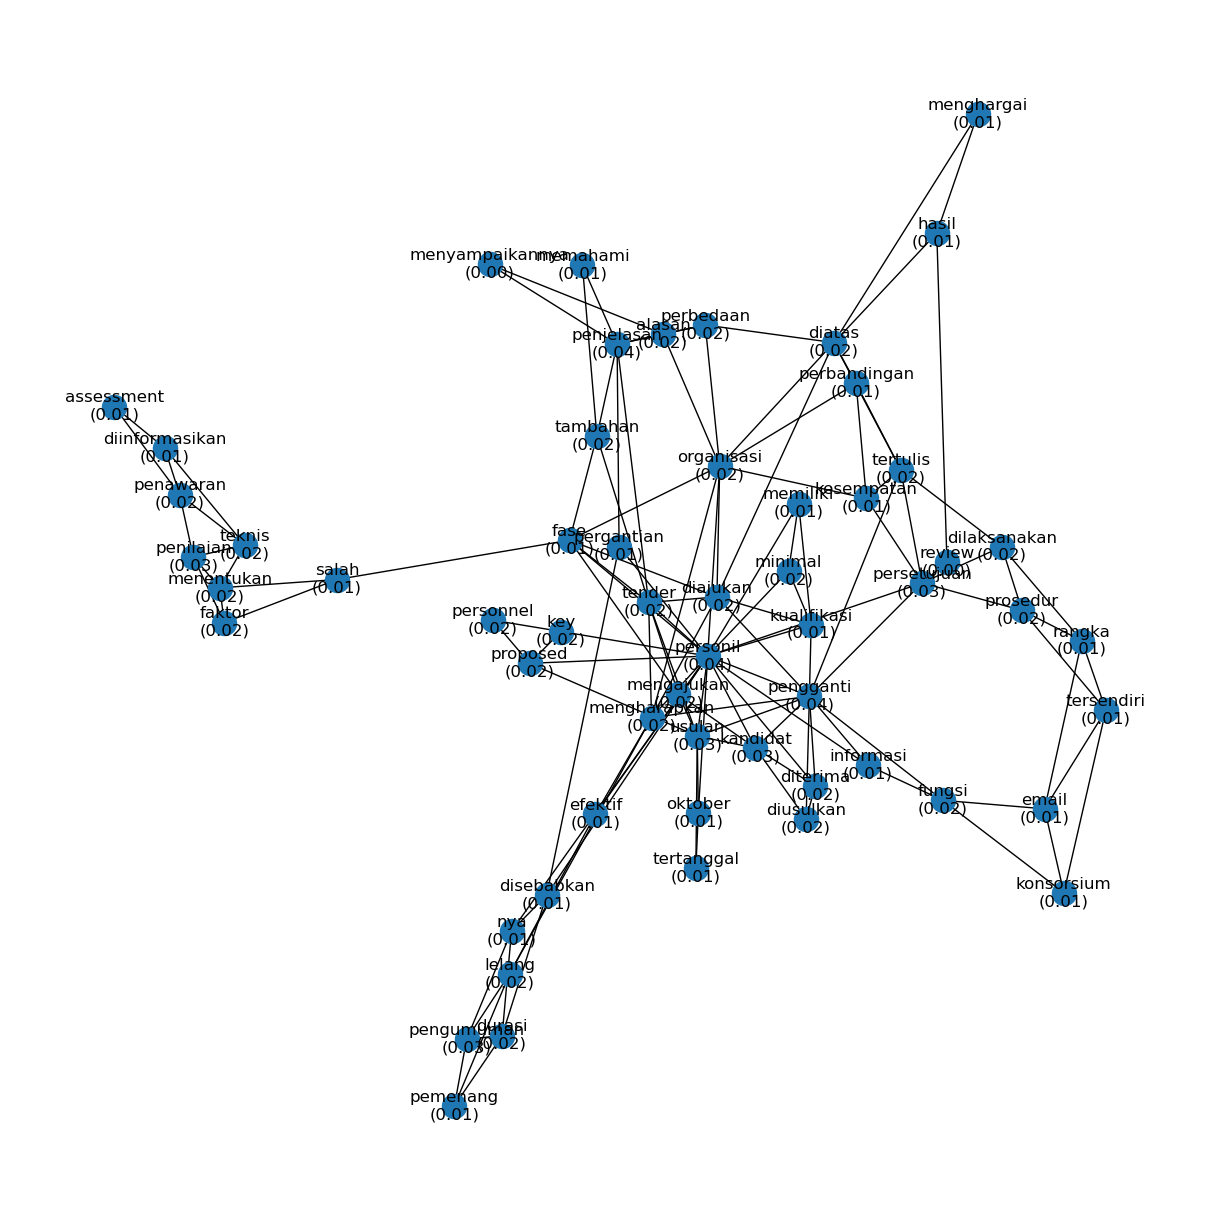

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize the graph
visualize_graph(G, labels)


13a_TextRank_w2v_sm_sim

In [20]:
model_path = os.path.join(repo_root, "models/own_200/word2vec_model_surat_lg.model")
w2v_model, available_tokens = load_word2vec_model(model_path)

# Show a sample of available tokens
sample_tokens = list(available_tokens)[:5]
sample_tokens

['telecommunication', 'program', 'tenta', 'filter', 'fmp']

In [ ]:
words = detect_all_tokens(text)
# Load stopwords for the specified language
stop_words = stopwords
    
# Filter out stopwords and punctuation
words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
words

In [22]:
# Build a co-occurrence matrix
co_occurrence = defaultdict(int)
window_size = 3
for i in range(len(words) - window_size + 1):
    window = words[i:i+window_size]
    for j in range(window_size):
        for k in range(j+1, window_size):
            w1, w2 = sorted([window[j], window[k]])
            if w1 != w2:
                co_occurrence[(w1, w2)] += 1
    
# Build a graph
G = nx.Graph()
for (w1, w2), _ in co_occurrence.items():
    weight = get_cosine_similarity(w1, w2, w2v_model)
    if weight > 0:
        G.add_edge(w1, w2, weight=weight)
# Compute TextRank scores
scores = nx.pagerank(G)
scores

{'personil': 0.06924010797626155,
 'usulan': 0.022015248916118176,
 'proposed': 0.013308931271755397,
 'key': 0.014734736294882214,
 'personnel': 0.013692954800143656,
 'b': 0.012926024785176774,
 'tertanggal': 0.013737361517207626,
 'oktober': 0.012994798242564914,
 'pengganti': 0.04139219476943338,
 'diajukan': 0.023037383584473835,
 'fase': 0.025307758471011306,
 'tender': 0.03403111884301178,
 'tambahan': 0.013828571470630706,
 'penjelasan': 0.022644847106217947,
 'memahami': 0.01348028845506274,
 'pergantian': 0.011248254672363069,
 'disebabkan': 0.013076626198281883,
 'nya': 0.014679934742292391,
 'durasi': 0.01550757749333487,
 'pengumuman': 0.014928206390242102,
 'pemenang': 0.015069159422165758,
 'lelang': 0.014050187525126314,
 'efektif': 0.013689921663179814,
 'mengharapkan': 0.02353624923146174,
 'memiliki': 0.013901632296852073,
 'kualifikasi': 0.01652072296564144,
 'minimal': 0.010462407286972472,
 'organisasi': 0.03055431079913871,
 'salah': 0.014322375476925648,
 'fakto

In [23]:
# Prepare labels
labels = {node: f'{node}\n({score:.2f})' for node, score in scores.items()}
labels 

{'personil': 'personil\n(0.07)',
 'usulan': 'usulan\n(0.02)',
 'proposed': 'proposed\n(0.01)',
 'key': 'key\n(0.01)',
 'personnel': 'personnel\n(0.01)',
 'b': 'b\n(0.01)',
 'tertanggal': 'tertanggal\n(0.01)',
 'oktober': 'oktober\n(0.01)',
 'pengganti': 'pengganti\n(0.04)',
 'diajukan': 'diajukan\n(0.02)',
 'fase': 'fase\n(0.03)',
 'tender': 'tender\n(0.03)',
 'tambahan': 'tambahan\n(0.01)',
 'penjelasan': 'penjelasan\n(0.02)',
 'memahami': 'memahami\n(0.01)',
 'pergantian': 'pergantian\n(0.01)',
 'disebabkan': 'disebabkan\n(0.01)',
 'nya': 'nya\n(0.01)',
 'durasi': 'durasi\n(0.02)',
 'pengumuman': 'pengumuman\n(0.01)',
 'pemenang': 'pemenang\n(0.02)',
 'lelang': 'lelang\n(0.01)',
 'efektif': 'efektif\n(0.01)',
 'mengharapkan': 'mengharapkan\n(0.02)',
 'memiliki': 'memiliki\n(0.01)',
 'kualifikasi': 'kualifikasi\n(0.02)',
 'minimal': 'minimal\n(0.01)',
 'organisasi': 'organisasi\n(0.03)',
 'salah': 'salah\n(0.01)',
 'faktor': 'faktor\n(0.01)',
 'menentukan': 'menentukan\n(0.02)',
 'pen

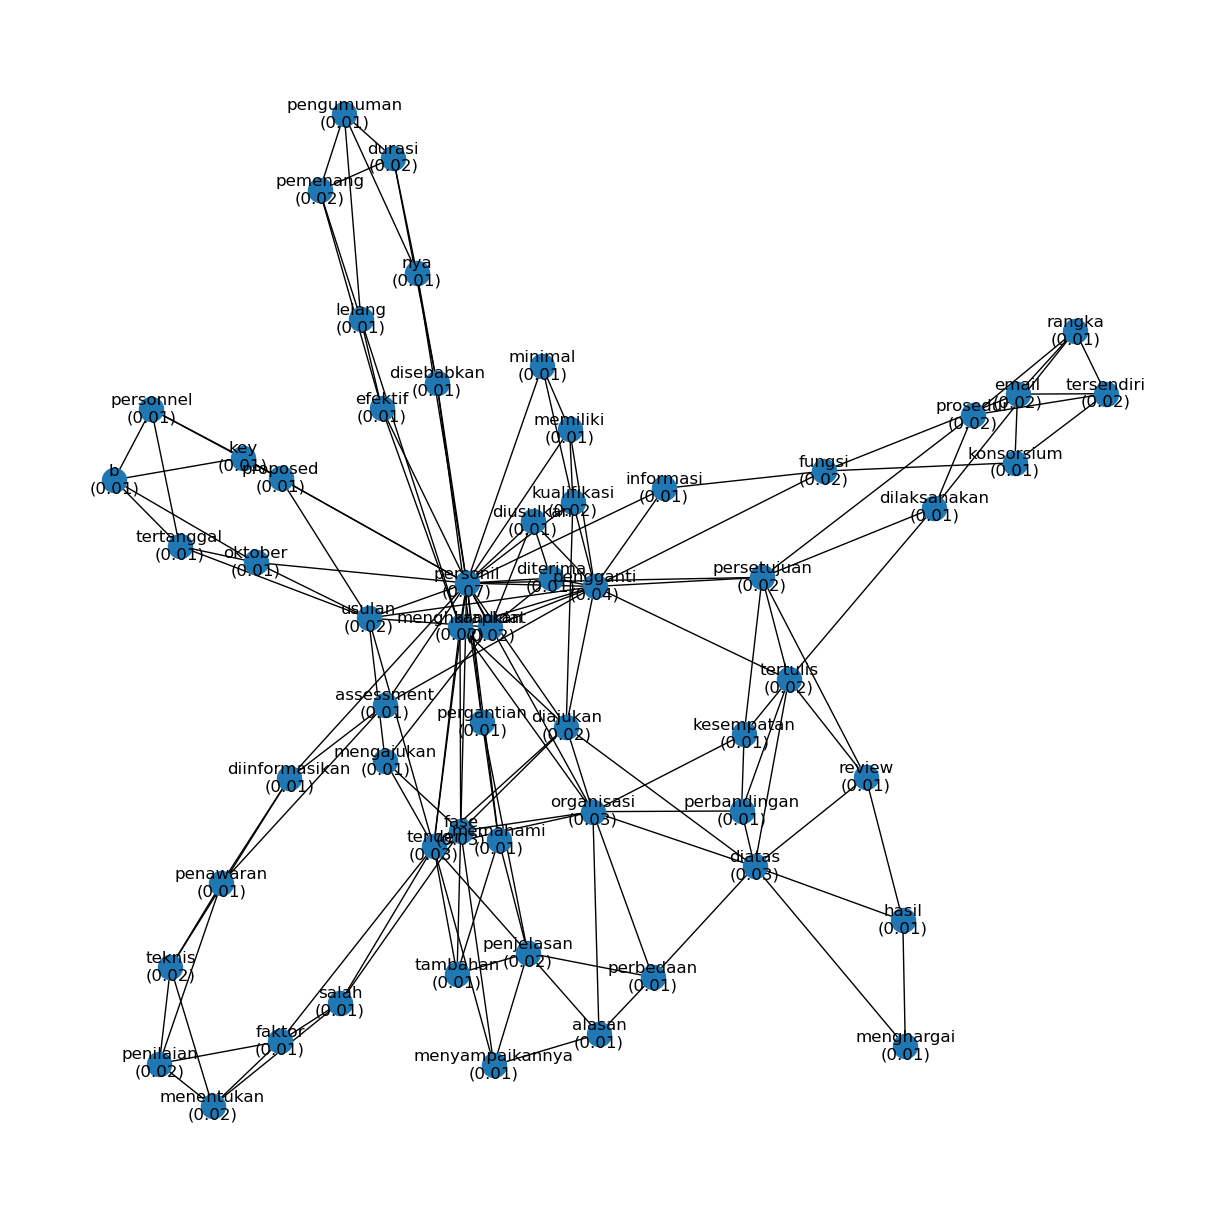

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize the graph
visualize_graph(G, labels)

13b_TextRank_w2v_lg_combined

In [ ]:
words = detect_all_tokens(text)
# Load stopwords for the specified language
stop_words = stopwords
    
# Filter out stopwords and punctuation
words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
words

In [26]:
# Build a co-occurrence matrix
co_occurrence = defaultdict(int)
window_size = 3
for i in range(len(words) - window_size + 1):
    window = words[i:i+window_size]
    for j in range(window_size):
        for k in range(j+1, window_size):
            w1, w2 = sorted([window[j], window[k]])
            if w1 != w2:
                co_occurrence[(w1, w2)] += 1
    
# Build a graph
G = nx.Graph()
for (w1, w2), weight1 in co_occurrence.items():
    weight2 = get_cosine_similarity(w1, w2, w2v_model)
    weight3 = weight1 * weight2
    if weight2 > 0:
        G.add_edge(w1, w2, weight=weight3)
    
# Compute TextRank scores
scores = nx.pagerank(G)
scores

{'personil': 0.07891733029937062,
 'usulan': 0.019862756626117074,
 'proposed': 0.011634387141354481,
 'key': 0.013919640402595483,
 'personnel': 0.01280391678113684,
 'b': 0.012123169712105475,
 'tertanggal': 0.013116517037889608,
 'oktober': 0.011755599095262557,
 'pengganti': 0.0417862715751497,
 'diajukan': 0.04152659404691446,
 'fase': 0.04260465794571479,
 'tender': 0.045515524714777274,
 'tambahan': 0.010637819313010595,
 'penjelasan': 0.020279529656316096,
 'memahami': 0.011166997247275113,
 'pergantian': 0.00937424638887348,
 'disebabkan': 0.011553522234074519,
 'nya': 0.013497719207567236,
 'durasi': 0.014456769083573753,
 'pengumuman': 0.014215941210573143,
 'pemenang': 0.014157371619892665,
 'lelang': 0.012939750868623628,
 'efektif': 0.011848509508578884,
 'mengharapkan': 0.017636233465713743,
 'memiliki': 0.01094273736139448,
 'kualifikasi': 0.016746255537320905,
 'minimal': 0.01078871277331847,
 'organisasi': 0.04212437081073226,
 'salah': 0.011574877298480172,
 'faktor'

In [27]:
# Prepare labels
labels = {node: f'{node}\n({score:.2f})' for node, score in scores.items()}
labels

{'personil': 'personil\n(0.08)',
 'usulan': 'usulan\n(0.02)',
 'proposed': 'proposed\n(0.01)',
 'key': 'key\n(0.01)',
 'personnel': 'personnel\n(0.01)',
 'b': 'b\n(0.01)',
 'tertanggal': 'tertanggal\n(0.01)',
 'oktober': 'oktober\n(0.01)',
 'pengganti': 'pengganti\n(0.04)',
 'diajukan': 'diajukan\n(0.04)',
 'fase': 'fase\n(0.04)',
 'tender': 'tender\n(0.05)',
 'tambahan': 'tambahan\n(0.01)',
 'penjelasan': 'penjelasan\n(0.02)',
 'memahami': 'memahami\n(0.01)',
 'pergantian': 'pergantian\n(0.01)',
 'disebabkan': 'disebabkan\n(0.01)',
 'nya': 'nya\n(0.01)',
 'durasi': 'durasi\n(0.01)',
 'pengumuman': 'pengumuman\n(0.01)',
 'pemenang': 'pemenang\n(0.01)',
 'lelang': 'lelang\n(0.01)',
 'efektif': 'efektif\n(0.01)',
 'mengharapkan': 'mengharapkan\n(0.02)',
 'memiliki': 'memiliki\n(0.01)',
 'kualifikasi': 'kualifikasi\n(0.02)',
 'minimal': 'minimal\n(0.01)',
 'organisasi': 'organisasi\n(0.04)',
 'salah': 'salah\n(0.01)',
 'faktor': 'faktor\n(0.01)',
 'menentukan': 'menentukan\n(0.01)',
 'pen

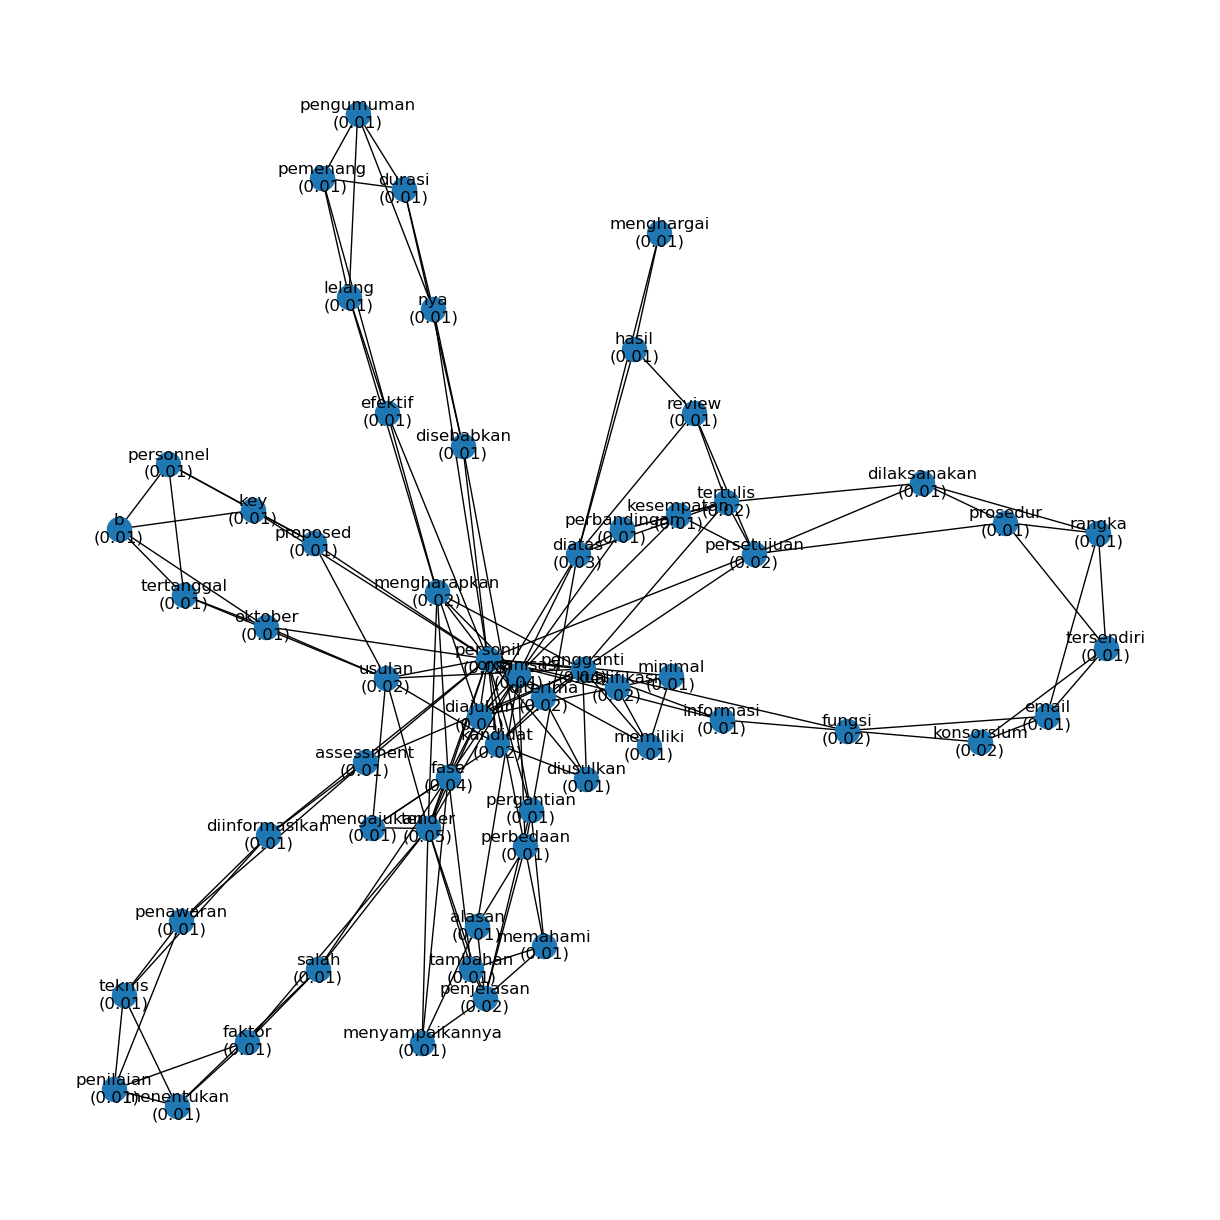

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize the graph
visualize_graph(G, labels)

13b_TextRank_w2v_sm_combined

In [29]:
# Example usage
model_path = os.path.join(repo_root, "models/own_200/word2vec_model_surat_lg.model")
w2v_model, available_tokens = load_word2vec_model(model_path)

# Show a sample of available tokens
sample_tokens = list(available_tokens)[:5]
sample_tokens

['telecommunication', 'program', 'tenta', 'filter', 'fmp']

In [ ]:
words = detect_all_tokens(text)
# Load stopwords for the specified language
stop_words = stopwords
    
# Filter out stopwords and punctuation
words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
words

In [31]:
# Build a co-occurrence matrix
co_occurrence = defaultdict(int)
window_size = 3
for i in range(len(words) - window_size + 1):
    window = words[i:i+window_size]
    for j in range(window_size):
        for k in range(j+1, window_size):
            w1, w2 = sorted([window[j], window[k]])
            if w1 != w2:
                co_occurrence[(w1, w2)] += 1
    
# Build a graph
G = nx.Graph()
for (w1, w2), weight1 in co_occurrence.items():
    weight2 = get_cosine_similarity(w1, w2, w2v_model)
    weight3 = weight1 * weight2
    if weight2 > 0:
        G.add_edge(w1, w2, weight=weight3)
    
# Compute TextRank scores
scores = nx.pagerank(G)
scores

{'personil': 0.07891733029937062,
 'usulan': 0.019862756626117074,
 'proposed': 0.011634387141354481,
 'key': 0.013919640402595483,
 'personnel': 0.01280391678113684,
 'b': 0.012123169712105475,
 'tertanggal': 0.013116517037889608,
 'oktober': 0.011755599095262557,
 'pengganti': 0.0417862715751497,
 'diajukan': 0.04152659404691446,
 'fase': 0.04260465794571479,
 'tender': 0.045515524714777274,
 'tambahan': 0.010637819313010595,
 'penjelasan': 0.020279529656316096,
 'memahami': 0.011166997247275113,
 'pergantian': 0.00937424638887348,
 'disebabkan': 0.011553522234074519,
 'nya': 0.013497719207567236,
 'durasi': 0.014456769083573753,
 'pengumuman': 0.014215941210573143,
 'pemenang': 0.014157371619892665,
 'lelang': 0.012939750868623628,
 'efektif': 0.011848509508578884,
 'mengharapkan': 0.017636233465713743,
 'memiliki': 0.01094273736139448,
 'kualifikasi': 0.016746255537320905,
 'minimal': 0.01078871277331847,
 'organisasi': 0.04212437081073226,
 'salah': 0.011574877298480172,
 'faktor'

In [32]:
labels = {node: f'{node}\n({score:.2f})' for node, score in scores.items()}
labels

{'personil': 'personil\n(0.08)',
 'usulan': 'usulan\n(0.02)',
 'proposed': 'proposed\n(0.01)',
 'key': 'key\n(0.01)',
 'personnel': 'personnel\n(0.01)',
 'b': 'b\n(0.01)',
 'tertanggal': 'tertanggal\n(0.01)',
 'oktober': 'oktober\n(0.01)',
 'pengganti': 'pengganti\n(0.04)',
 'diajukan': 'diajukan\n(0.04)',
 'fase': 'fase\n(0.04)',
 'tender': 'tender\n(0.05)',
 'tambahan': 'tambahan\n(0.01)',
 'penjelasan': 'penjelasan\n(0.02)',
 'memahami': 'memahami\n(0.01)',
 'pergantian': 'pergantian\n(0.01)',
 'disebabkan': 'disebabkan\n(0.01)',
 'nya': 'nya\n(0.01)',
 'durasi': 'durasi\n(0.01)',
 'pengumuman': 'pengumuman\n(0.01)',
 'pemenang': 'pemenang\n(0.01)',
 'lelang': 'lelang\n(0.01)',
 'efektif': 'efektif\n(0.01)',
 'mengharapkan': 'mengharapkan\n(0.02)',
 'memiliki': 'memiliki\n(0.01)',
 'kualifikasi': 'kualifikasi\n(0.02)',
 'minimal': 'minimal\n(0.01)',
 'organisasi': 'organisasi\n(0.04)',
 'salah': 'salah\n(0.01)',
 'faktor': 'faktor\n(0.01)',
 'menentukan': 'menentukan\n(0.01)',
 'pen

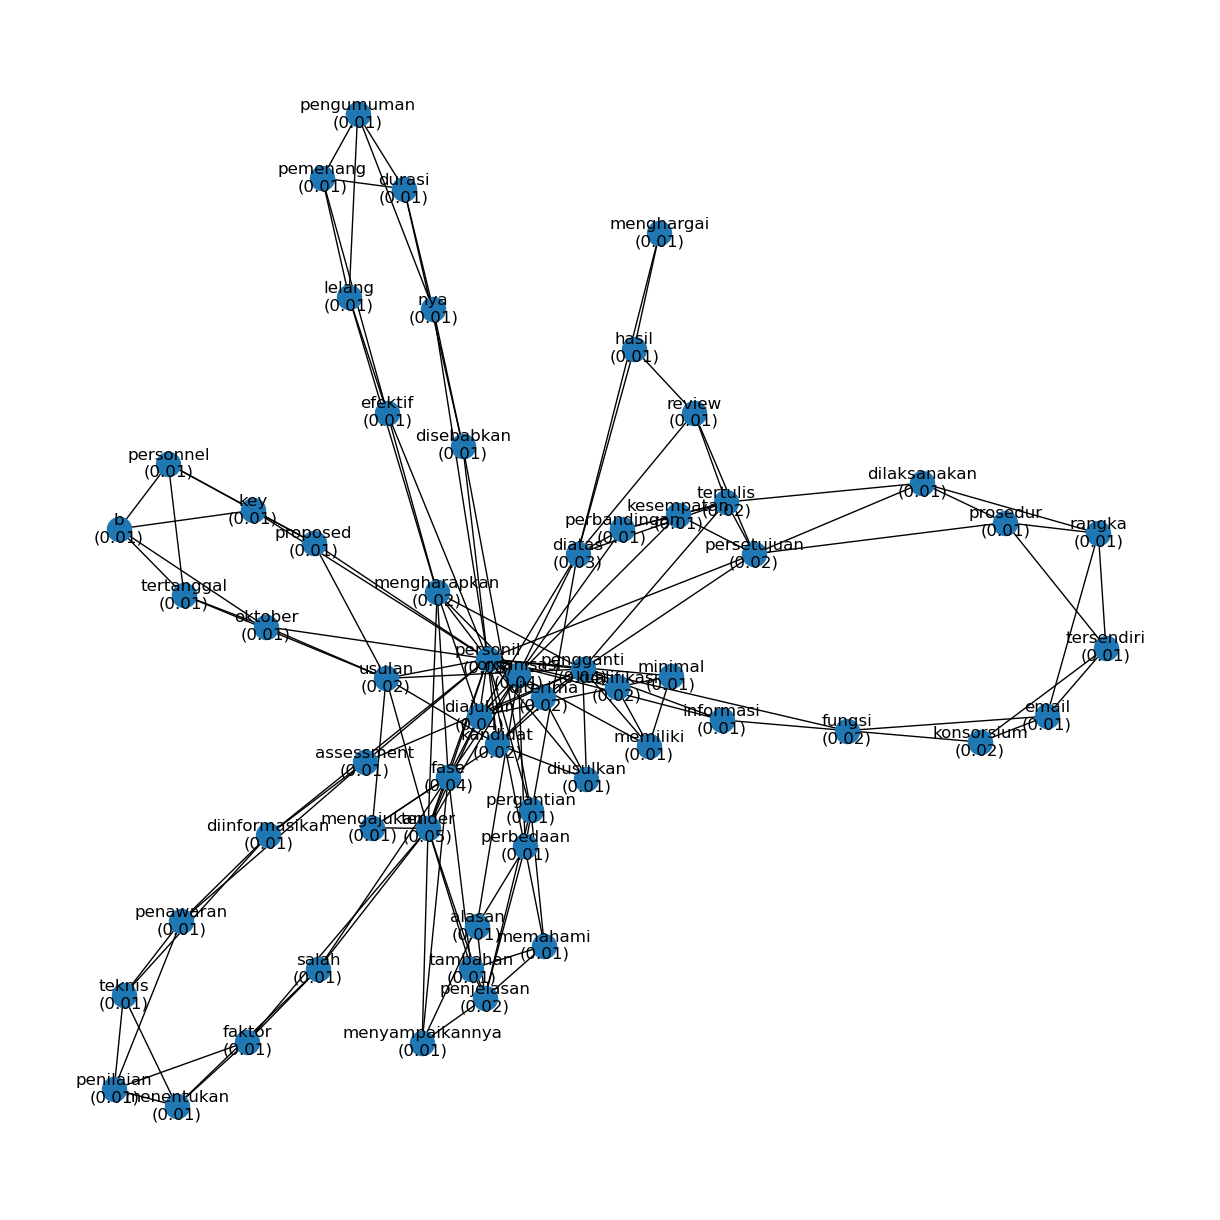

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize the graph
visualize_graph(G, labels)
